# Prophet training
- This is an auto-generated notebook.
- To reproduce these results, attach this notebook to a cluster with runtime version **13.0.x-cpu-ml-scala2.12**, and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/3922847372101687).
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "num_sold"
time_col = "date"
unit = "day"

horizon = 10

## Load Data

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join("/dbfs/tmp/", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="5c563a0d265344f58fddab54c2080272", artifact_path="data", dst_path=input_temp_dir)

input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

# Preview data
df_loaded.head(5)

,date,num_sold
0,2019-04-07,29
1,2019-04-07,30
2,2019-04-07,4
3,2019-04-07,27
4,2019-04-07,30


## Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index()

df_aggregated.head()

,date,y
0,2019-05-08,168.826667
1,2019-04-28,186.000000
2,2019-04-26,172.120000
3,2019-05-04,189.706667
4,2019-04-16,150.840000


## Train Prophet model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/3922847372101687)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
import logging

# disable informational messages from prophet
logging.getLogger("py4j").setLevel(logging.WARNING)

In [0]:
result_columns = ["model_json", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def prophet_training(history_pd):
  from hyperopt import hp
  from databricks.automl_runtime.forecast.prophet.forecast import ProphetHyperoptEstimator

  seasonality_mode = ["additive", "multiplicative"]
  search_space =  {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    "seasonality_mode": hp.choice("seasonality_mode", seasonality_mode)
  }
  country_holidays="US"
  run_parallel = True
 
  hyperopt_estim = ProphetHyperoptEstimator(horizon=horizon, frequency_unit=unit, metric="smape",interval_width=0.95,
                   country_holidays=country_holidays, search_space=search_space, num_folds=20, max_eval=10, trial_timeout=6956,
                   random_state=21892207, is_parallel=run_parallel)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "false")

  results_pd = hyperopt_estim.fit(history_pd)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "true")
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, ProphetModel

with mlflow.start_run(experiment_id="3922847372101687", run_name="Prophet") as mlflow_run:
  mlflow.set_tag("estimator_name", "Prophet")
  mlflow.log_param("holiday_country", "US")
  mlflow.log_param("interval_width", 0.95)
  df_aggregated = df_aggregated.rename(columns={time_col: "ds"})

  forecast_results = prophet_training(df_aggregated.to_pandas())
    
  # Log the metrics to mlflow
  avg_metrics = forecast_results[["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Create mlflow prophet model
  model_json = forecast_results["model_json"].to_list()[0]
  prophet_model = ProphetModel(model_json, horizon, unit, time_col)
  mlflow_prophet_log_model(prophet_model)

Because the requested parallelism was None or a non-positive value, parallelism will be set to (32), which is Spark's default parallelism (32), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt + MLflow integration is feature-flagged off.  To enable automatic tracking in MLflow, set via: `spark.conf.set('spark.databricks.mlflow.trackHyperopt.enabled', 'true')` where `spark` is your SparkSession.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 10/10 [00:24<00:00,  2.41s/trial, best loss: 0.03171871140416804]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
09:32:00 - cmdstanpy - INFO - Chain [1] start processing
09:32:00 - cmdstanpy - INFO - Chain [1] done processing
09:32:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
Optimization terminated abnormally. Falling back to Newton.
09:32:00 - cmdstanpy - INFO - Chain [1] start processing
09:32:09 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
/databricks/python/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning

In [0]:
forecast_results.head(10)

,model_json,mse,rmse,mae,mape,mdape,smape,coverage
0,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",112.748872,9.752042,6.118953,0.030904,0.021993,0.031719,0.975


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

In [0]:
future_df = loaded_model._model_impl.python_model.make_future_dataframe()
future_df.head()

/databricks/python/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


,ds
0,2019-04-07
1,2019-04-08
2,2019-04-09
3,2019-04-10
4,2019-04-11


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.model().predict(future_df)

/databricks/python/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [0]:
# Plotly plots is turned off by default because it takes up a lot of storage.
# Set this flag to True and re-run the notebook to see the interactive plots with plotly
use_plotly = False

In [0]:
# Get prophet model
model = loaded_model._model_impl.python_model.model()
predict_pd = forecast_pd
predict_pd

/databricks/python/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


,level_0,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,0,0,2019-04-07,166.782613,157.286708,199.720514,166.782613,166.782613,0.0,0.0,...,0.136326,0.136326,0.136326,-0.064359,-0.064359,-0.064359,0.0,0.0,0.0,178.785420
1,1,1,2019-04-08,166.741073,127.782556,165.997058,166.741073,166.741073,0.0,0.0,...,-0.051002,-0.051002,-0.051002,-0.068662,-0.068662,-0.068662,0.0,0.0,0.0,146.788138
2,2,2,2019-04-09,166.699533,126.171262,165.602253,166.699533,166.699533,0.0,0.0,...,-0.051460,-0.051460,-0.051460,-0.072366,-0.072366,-0.072366,0.0,0.0,0.0,146.057799
3,3,3,2019-04-10,166.657993,123.724215,165.771479,166.657993,166.657993,0.0,0.0,...,-0.051331,-0.051331,-0.051331,-0.075404,-0.075404,-0.075404,0.0,0.0,0.0,145.536609
4,4,4,2019-04-11,166.616453,124.163829,164.807403,166.616453,166.616453,0.0,0.0,...,-0.050893,-0.050893,-0.050893,-0.077727,-0.077727,-0.077727,0.0,0.0,0.0,145.186293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1005,1005,2022-01-06,185.641749,195.926517,234.318503,185.633149,185.649030,0.0,0.0,...,-0.050893,-0.050893,-0.050893,0.208053,0.208053,0.208053,0.0,0.0,0.0,214.817125
1006,1006,1006,2022-01-07,185.697906,207.000903,246.931262,185.684666,185.710336,0.0,0.0,...,0.016441,0.016441,0.016441,0.202141,0.202141,0.202141,0.0,0.0,0.0,226.287992
1007,1007,1007,2022-01-08,185.754064,211.891859,251.738983,185.734150,185.770355,0.0,0.0,...,0.051919,0.051919,0.051919,0.194839,0.194839,0.194839,0.0,0.0,0.0,231.590350
1008,1008,1008,2022-01-09,185.810222,225.330801,266.209292,185.787269,185.830263,0.0,0.0,...,0.136326,0.136326,0.136326,0.186277,0.186277,0.186277,0.0,0.0,0.0,245.753174


### Plot the forecast with change points and trend
Plot the forecast using the `plot` method with your forecast dataframe. You can use `prophet.plot.add_changepoints_to_plot` to overlay significant changepoints. An interactive figure can be created with plotly.

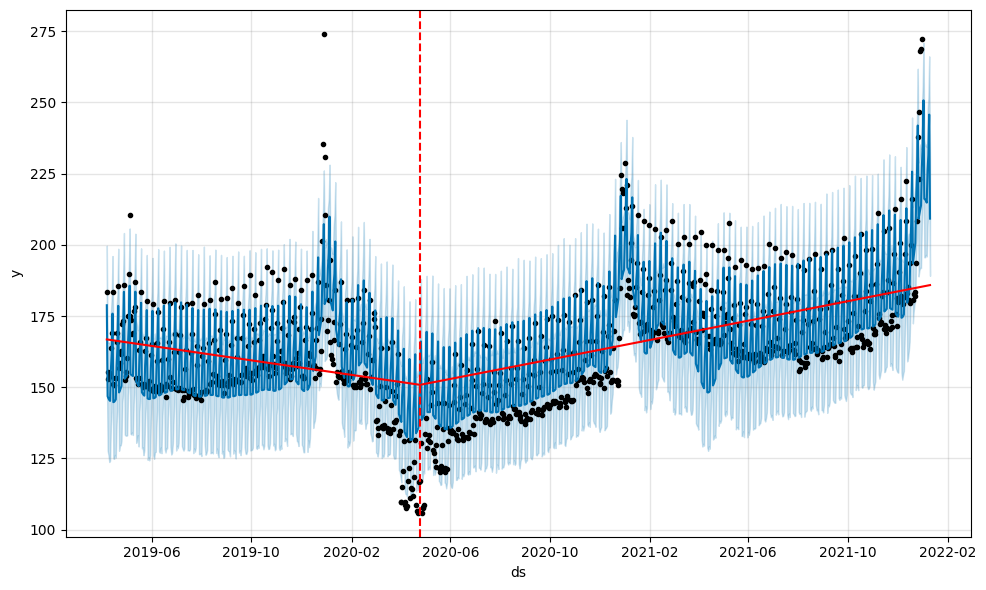

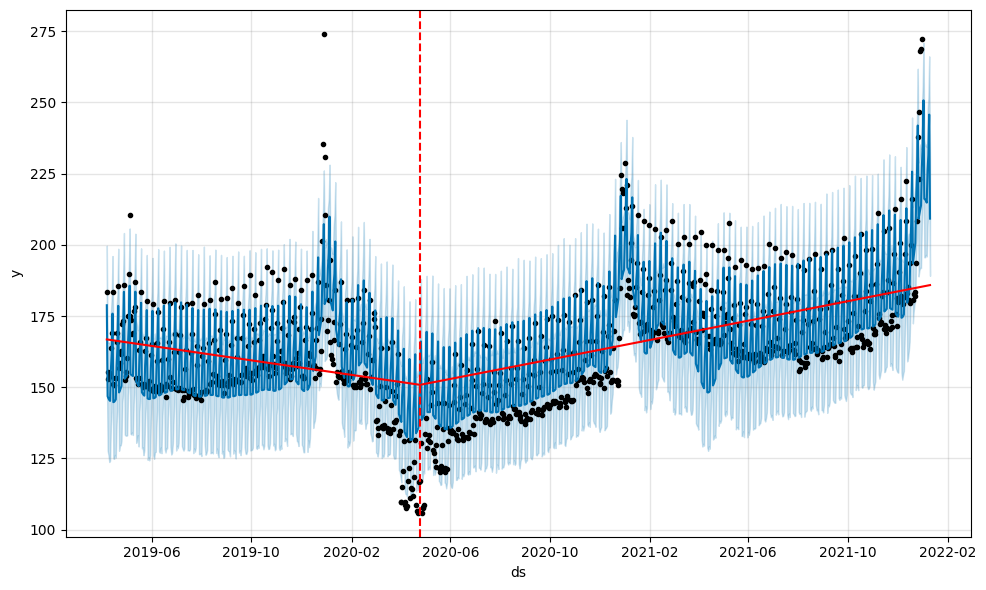

In [0]:
from prophet.plot import add_changepoints_to_plot, plot_plotly

if use_plotly:
    fig = plot_plotly(model, predict_pd, changepoints=True, trend=True, figsize=(1200, 600))
else:
    fig = model.plot(predict_pd)
    a = add_changepoints_to_plot(fig.gca(), model, predict_pd)
fig

### Plot the forecast components
Use the `Prophet.plot_components` method to see the components. By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series. You can also include holidays. An interactive figure can be created with plotly.

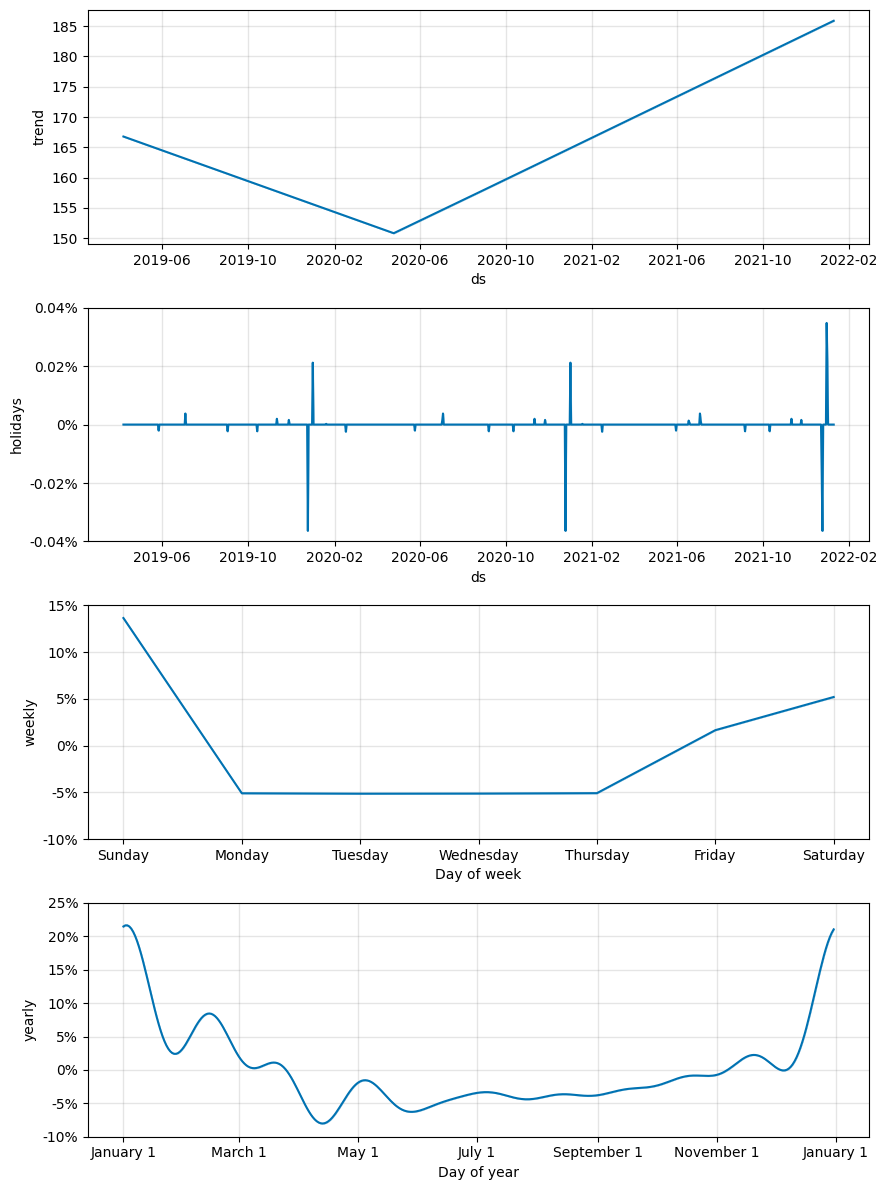

In [0]:
from prophet.plot import plot_components_plotly
if use_plotly:
    fig = plot_components_plotly(model, predict_pd, figsize=(900, 400))
    fig.show()
else:
    fig = model.plot_components(predict_pd)

## Show the predicted results

In [0]:
predict_cols = ["ds", "yhat"]
# forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

ds,yhat
2022-01-01T00:00:00.000+0000,234.69505355567142
2022-01-02T00:00:00.000+0000,250.76107895973539
2022-01-03T00:00:00.000+0000,216.17289104118566
2022-01-04T00:00:00.000+0000,215.92798787834954
2022-01-05T00:00:00.000+0000,215.49030406053606
2022-01-06T00:00:00.000+0000,214.8171251839295
2022-01-07T00:00:00.000+0000,226.28799234823208
2022-01-08T00:00:00.000+0000,231.59034955886048
2022-01-09T00:00:00.000+0000,245.7531741075834
2022-01-10T00:00:00.000+0000,209.21280242844895
